### Installing required libraries

In [1]:
"""
Importing all the needed libraries for the project:
"""
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm1
from scipy.stats import linregress
import matplotlib.dates as mdates
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model   import LinearRegression, Lasso, Ridge
from sklearn.model_selection import TimeSeriesSplit,ParameterGrid
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
from sklearn.model_selection  import PredefinedSplit, GridSearchCV
from sklearn.base import clone
import warnings
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import gdown
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit

import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')

#### Loading the new data in (after feature eng + HMM + trend scanning)

In [2]:
url_train = "https://drive.google.com/uc?id=1RmrpUfiqfqOp5Jb5attauKcltLEx1zKh"
url_test  = "https://drive.google.com/uc?id=1ONursxl7CKdAlf0t_Slmy2_w_Bzj2QbB"
url_all = "https://drive.google.com/uc?id=1drMM8_c-43cOmGjirp4-CRz1RBwgFK_V"

prices_train = pd.read_csv(url_train, parse_dates=True, index_col=0)
prices_test  = pd.read_csv(url_test,  parse_dates=True, index_col=0)
prices  = pd.read_csv(url_all,  parse_dates=True, index_col=0)

In [58]:
prices.head()

,coin,open,high,low,close,volume,day,MVRV,n_unique_addresses,exchange_volume,...,cumret_regime_1,ret_regime_2,cumret_regime_2,is_regime_0,is_regime_1,is_regime_2,t1,tVal,bin,windowSize
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,BTC,13791.4,13804.9,13680.0,13680.0,5.922596,2018-01-01,2.922937,838926.0,1.506584e+09,...,0.0,0.000000,0.000000,0,0,1,2018-01-04 08:00:00,14.681708,1.0,79
2018-01-01 02:00:00,BTC,13500.4,13600.0,13480.0,13514.0,9.326084,2018-01-01,2.922937,838926.0,1.506584e+09,...,0.0,-0.012209,-0.012209,0,0,1,2018-01-04 08:00:00,14.657323,1.0,78
2018-01-01 03:00:00,BTC,13512.0,13576.4,13512.0,13560.2,11.704644,2018-01-01,2.922937,838926.0,1.506584e+09,...,0.0,0.003413,-0.008796,0,0,1,2018-01-04 06:00:00,14.480517,1.0,75
2018-01-01 04:00:00,BTC,13694.8,13809.8,13667.4,13667.4,17.126073,2018-01-01,2.922937,838926.0,1.506584e+09,...,0.0,0.007874,-0.000921,0,0,1,2018-01-04 06:00:00,14.334101,1.0,74
2018-01-01 05:00:00,BTC,13763.3,13887.9,13658.6,13765.0,9.322753,2018-01-01,2.922937,838926.0,1.506584e+09,...,0.0,0.007116,0.006194,0,0,1,2018-01-04 06:00:00,14.285700,1.0,73


In [4]:
prices.describe()

,open,high,low,close,volume,MVRV,n_unique_addresses,exchange_volume,nvt,log_close,...,ret_regime_1,cumret_regime_1,ret_regime_2,cumret_regime_2,is_regime_0,is_regime_1,is_regime_2,tVal,bin,windowSize
count,34968.000000,34968.000000,34968.000000,34968.000000,34968.000000,34968.000000,34968.000000,3.496800e+04,34968.000000,34968.000000,...,34968.000000,34968.000000,34968.000000,34968.000000,34968.000000,34968.000000,34968.000000,34968.000000,34968.000000,34968.000000
mean,18248.930248,18297.737490,18199.769793,18249.025887,999.855134,1.803139,574332.425189,3.916591e+08,14.358440,9.421541,...,0.000017,0.232925,-0.000023,-0.794431,0.436628,0.272764,0.290609,1.317318,0.079444,66.574725
std,17711.816605,17763.163873,17660.380900,17712.056664,2349.628308,0.656030,125113.823848,3.877460e+08,6.556573,0.840999,...,0.001471,0.242568,0.008023,0.256649,0.495975,0.445387,0.454050,14.007365,0.996854,26.540868
min,3140.600000,3150.500000,3134.800000,3140.300000,0.000000,0.696531,310120.000000,2.860097e+07,1.759735,8.052074,...,-0.014098,-0.125987,-0.260965,-1.524616,0.000000,0.000000,0.000000,-20.000000,-1.000000,15.000000
25%,7075.800000,7089.900000,7058.550000,7074.875000,14.948509,1.314843,476263.000000,1.395876e+08,8.976419,8.864305,...,0.000000,-0.010674,0.000000,-0.989741,0.000000,0.000000,0.000000,-11.911915,-1.000000,43.000000
50%,9419.850000,9433.550000,9402.900000,9420.600000,49.052915,1.680593,555616.000000,2.791290e+08,13.282818,9.150654,...,0.000000,0.223281,0.000000,-0.847584,0.000000,0.000000,0.000000,6.687860,1.000000,71.000000
75%,26962.172500,27118.995000,26900.947500,27049.075000,1108.822750,2.133453,663855.000000,5.039615e+08,18.851695,10.205408,...,0.000000,0.529815,0.000000,-0.589604,1.000000,1.000000,1.000000,13.705596,1.000000,95.000000
max,68714.850000,68818.870000,68525.960000,68634.490000,79580.413000,3.759066,952400.000000,3.192479e+09,33.425411,11.136550,...,0.013903,0.603374,0.196563,0.224388,1.000000,1.000000,1.000000,20.000000,1.000000,95.000000


In [81]:
print("Full data set target variable balance check: ")
print(prices['bin'].value_counts())
print("Train data set target variable balance check: ")
print(prices_train['bin'].value_counts())

Full data set target variable balance check: 
 1.0    18873
-1.0    16095
Name: bin, dtype: int64
Train data set target variable balance check: 
 1.0    14226
-1.0    12077
Name: bin, dtype: int64


In [102]:
prices_train_meta = prices_train.copy() # for meta labelling later on

In [3]:
prices_train.drop(['coin','regime','ret_regime_1','ret_regime_0','cumret_regime_1','ret_regime_2','cumret_regime_0', 'ret_regime_1', 'cumret_regime_1', 'ret_regime_2',
       'cumret_regime_2','t1','tVal','windowSize','day'],axis=1,inplace=True)
prices_test.drop(['coin','regime','ret_regime_1','ret_regime_0','cumret_regime_1','ret_regime_2','cumret_regime_0', 'ret_regime_1', 'cumret_regime_1', 'ret_regime_2',
       'cumret_regime_2','t1','tVal','windowSize','day'],axis=1,inplace=True)

In [4]:
"""
DATA LOADING
"""

prices['year'] = prices.index.year
prices_train['year'] = prices_train.index.year
prices_test['year'] = prices_test.index.year


X_train = prices_train.drop(columns = ['bin'])
y_train = prices_train['bin'].replace({-1:0,1:1}).astype(int)

X_test = prices_test.drop(columns = ['bin'])
y_test = prices_test['bin'].replace({-1:0,1:1}).astype(int)

X_all = prices.drop(columns = ['bin'])
y_all = prices['bin'].replace({-1:0,1:1}).astype(int)

#### Preprocessing the data

In [5]:
def preprocess_data(df):
    special_log_cols     = ['MVRV', 'nvt']
    special_logdiff_cols = ['n_unique_addresses']
    special_log1p_cols   = ['exchange_volume']

    returns_vol_cols = [
        c for c in df.columns
        if c.startswith('return') or c.startswith('log_return') or c.startswith('volatility')
    ]
    ema_cols = [c for c in df.columns if c in ['ema21','ema35','ema80','ema250']]
    sma_cols = [c for c in df.columns if c in ['sma50','sma200','sma20']]
    other_cont = [
        'rsi14','bb_percent_b','bb_bandwidth','macd_line','macd_hist',
        'adx14','obv','bb_mid','bb_upper','bb_lower','bb_percent_b','bb_bandwidth',
        'plus_di14','minus_di14','%K','%D','obv_sma20'
    ]
    all_continuous = sma_cols + returns_vol_cols + ema_cols + other_cont + ['volume','vwap']
    rest_continuous = [
        c for c in all_continuous
        if c not in special_log_cols + special_logdiff_cols + special_log1p_cols
    ]

    binary_cols = [
        c for c in df.columns
        if c.endswith('cross') or c.endswith('above') or c.endswith('below') or c.startswith('is_regime')
    ]

    log_transform = FunctionTransformer(np.log1p, validate=True)

    def logdiff_column(X):
        col = X.astype(float).ravel()
        logged = np.log1p(col)
        diffed = np.diff(logged, prepend=logged[0])
        return diffed.reshape(-1, 1)
    logdiff_transform = FunctionTransformer(logdiff_column, validate=True)

    log1p_transform = FunctionTransformer(np.log1p, validate=True)

    mvrv_pipeline = Pipeline([('log', log_transform), ('scale', StandardScaler())])
    nvt_pipeline  = Pipeline([('log', log_transform), ('scale', StandardScaler())])
    nua_pipeline  = Pipeline([('logdiff', logdiff_transform), ('scale', StandardScaler())])
    exch_pipeline = Pipeline([('log1p', log1p_transform), ('scale', StandardScaler())])
    rest_pipeline = Pipeline([('scale', StandardScaler())])

    preprocessor = ColumnTransformer([
        ('mvrv_log',    mvrv_pipeline,     ['MVRV']),
        ('nvt_log',     nvt_pipeline,      ['nvt']),
        ('nua_logdiff', nua_pipeline,      ['n_unique_addresses']),
        ('exch_log1p',  exch_pipeline,     ['exchange_volume']),
        ('rest_cont_z', rest_pipeline,     rest_continuous),
        ('passthrough_bin', 'passthrough',  binary_cols),
    ], remainder='drop')

    return preprocessor

#Build template preprocessor for feature names
template_preprocessor = preprocess_data(prices)

In [6]:
# Helper to get transformed feature names
def get_transformed_feature_names():
    ct = template_preprocessor
    ct.fit(X_all.drop(columns=['year']))  # fitting on entire dataset for naming
    try:
        return ct.get_feature_names_out()
    except:
        # sklearn <1.0 compatibility
        output = []
        for name, trans, cols in ct.transformers_:
            if trans == 'drop':
                continue
            if trans == 'passthrough':
                output.extend(cols)
            else:
                # prefix each column with transformer name
                if hasattr(trans, 'named_steps'):
                    last_step = list(trans.named_steps.keys())[-1]
                    for col in cols:
                        output.append(f"{name}__{col}")
                else:
                    for col in cols:
                        output.append(f"{name}__{col}")
        return np.array(output)

feat_names = get_transformed_feature_names()

### Baseline model

In [14]:
def run_baseline_rf(X, y, split_type='timeseries'):
    """
    Baseline RandomForest:
      - 'timeseries': uses X_train/y_train for CV and X_test/y_test for hold‐out
      - 'year': uses X_all/y_all, leave‐one‐year‐out CV, final train on 2018–2020 and test on 2021
    Returns nicely formatted metrics and plots top‐10 feature importances.
    """
    # Prepare
    if 'year' in X.columns:
        X = X.drop(columns=['year'])
    n = len(X)
    oof_preds = np.zeros(n, dtype=int)
    fi_list = []

    # Build splits
    if split_type == 'timeseries':
        tscv = TimeSeriesSplit(n_splits=3)
        splits = list(tscv.split(np.arange(n)))
    else:
        years = X_all['year'].unique()
        splits = []
        for yr in years:
            train_idx = X_all[X_all['year'] != yr].index
            val_idx   = X_all[X_all['year'] == yr].index
            train_idx = [X.index.get_loc(i) for i in train_idx if i in X.index]
            val_idx   = [X.index.get_loc(i) for i in val_idx if i in X.index]
            if len(train_idx) and len(val_idx):
                splits.append((train_idx, val_idx))

    # CV loop
    for train_idx, val_idx in splits:
        pre = preprocess_data(prices)
        X_train_proc = pre.fit_transform(X.iloc[train_idx])
        X_val_proc   = pre.transform(X.iloc[val_idx])

        y_train_fold = y.iloc[train_idx]
        y_val_fold   = y.iloc[val_idx]

        rf = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )
        rf.fit(X_train_proc, y_train_fold)

        fi_list.append(rf.feature_importances_)
        oof_preds[val_idx] = rf.predict(X_val_proc)

    # Compute OOF metrics
    valid_mask = np.zeros(n, dtype=bool)
    for _, val_idx in splits:
        valid_mask[val_idx] = True

    y_true_oof = y.iloc[valid_mask].to_numpy()
    y_pred_oof = oof_preds[valid_mask]

    oof_acc = accuracy_score(y_true_oof, y_pred_oof)
    oof_bal = balanced_accuracy_score(y_true_oof, y_pred_oof)
    oof_f1  = f1_score(y_true_oof, y_pred_oof)
    oof_cm  = confusion_matrix(y_true_oof, y_pred_oof)

    # Top‐10 feature importances
    avg_fi = np.mean(np.vstack(fi_list), axis=0)
    top10_idx = np.argsort(avg_fi)[-10:][::-1]
    top10_feats = feat_names[top10_idx]
    top10_vals  = avg_fi[top10_idx]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=top10_vals, y=top10_feats, palette="viridis")
    plt.title(f"Top 10 Feature Importances ({split_type} CV)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    # Final train/test
    if split_type == 'timeseries':
        # Use X_train, y_train and X_test, y_test from outer scope
        pre_full = preprocess_data(prices)
        X_proc_train = pre_full.fit_transform(X_train)
        X_proc_test  = pre_full.transform(X_test)
        y_proc_train = y_train
        y_proc_test  = y_test
    else:
        # Use X_all, y_all split by year
        pre_full = preprocess_data(prices)
        train_mask = (prices['year'] <= 2020).values
        test_mask  = (prices['year'] == 2021).values
        X_proc_train = pre_full.fit_transform(X_all.iloc[train_mask])
        y_proc_train = y_all.iloc[train_mask]
        X_proc_test  = pre_full.transform(X_all.iloc[test_mask])
        y_proc_test  = y_all.iloc[test_mask]

    rf_full = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )
    rf_full.fit(X_proc_train, y_proc_train)
    test_preds = rf_full.predict(X_proc_test)

    test_acc = accuracy_score(y_proc_test, test_preds)
    test_bal = balanced_accuracy_score(y_proc_test, test_preds)
    test_f1  = f1_score(y_proc_test, test_preds)
    test_cm  = confusion_matrix(y_proc_test, test_preds)

    # Print metrics nicely
    print(f"===== {split_type.upper()} CV – OOF METRICS =====")
    print(f"Accuracy       : {oof_acc:.4f}")
    print(f"Balanced Acc   : {oof_bal:.4f}")
    print(f"F1 Score       : {oof_f1:.4f}")
    print("Confusion Matrix (OOF):")
    print(oof_cm)
    print()
    print(f"===== {split_type.upper()} CV – HOLD‐OUT TEST METRICS =====")
    print(f"Accuracy       : {test_acc:.4f}")
    print(f"Balanced Acc   : {test_bal:.4f}")
    print(f"F1 Score       : {test_f1:.4f}")
    print("Confusion Matrix (Test):")
    print(test_cm)
    print("="*50)

    return {
        "oof_metrics": {"acc": oof_acc, "balanced_acc": oof_bal, "f1": oof_f1, "cm": oof_cm},
        "test_metrics": {"acc": test_acc, "balanced_acc": test_bal, "f1": test_f1, "cm": test_cm}
    }

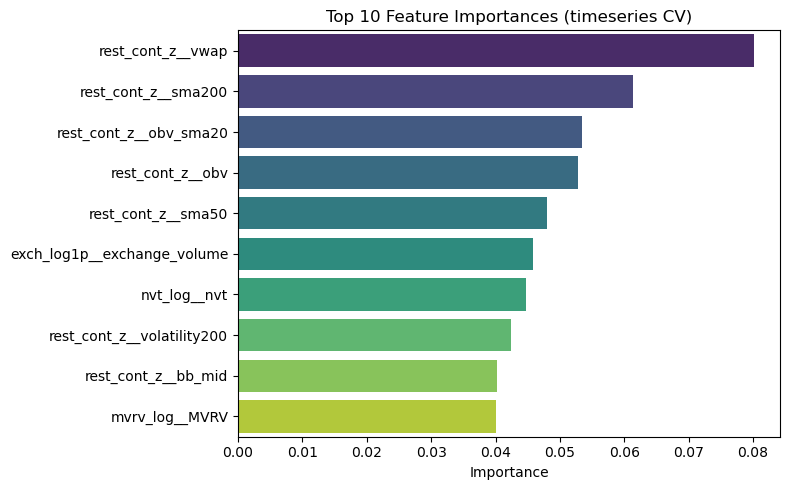

===== TIMESERIES CV – OOF METRICS =====
Accuracy       : 0.4793
Balanced Acc   : 0.4814
F1 Score       : 0.5004
Confusion Matrix (OOF):
[[4311 4334]
 [5937 5143]]

===== TIMESERIES CV – HOLD‐OUT TEST METRICS =====
Accuracy       : 0.5363
Balanced Acc   : 0.5000
F1 Score       : 0.6982
Confusion Matrix (Test):
[[   0 4018]
 [   0 4647]]


In [15]:
baseline_ts   = run_baseline_rf(X_train, y_train, split_type='timeseries')

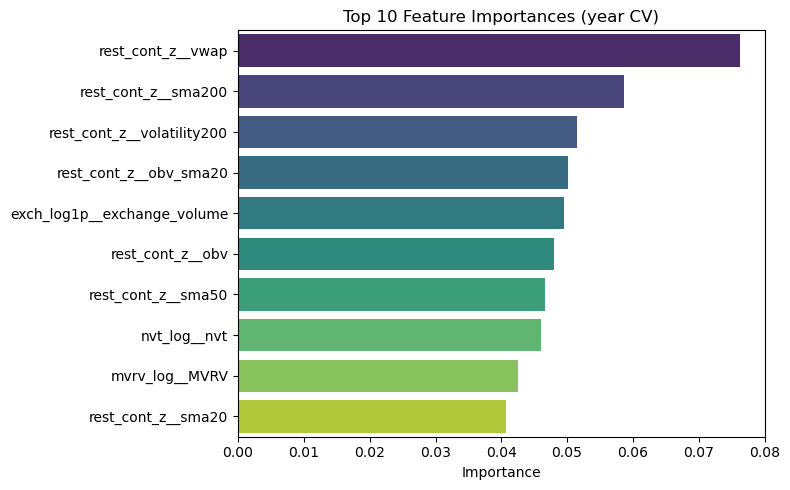

===== YEAR CV – OOF METRICS =====
Accuracy       : 0.4940
Balanced Acc   : 0.4773
F1 Score       : 0.5948
Confusion Matrix (OOF):
[[ 4288 11807]
 [ 5886 12987]]

===== YEAR CV – HOLD‐OUT TEST METRICS =====
Accuracy       : 0.5363
Balanced Acc   : 0.5000
F1 Score       : 0.6982
Confusion Matrix (Test):
[[   0 4018]
 [   0 4647]]


In [16]:
baseline_year = run_baseline_rf(X_all, y_all, split_type='year')

### LSTM

In [7]:
# ───────────────────────────────────────────────────────────────────────────────
# 1. SLIDING‐WINDOW DATASET FOR LSTM
# ───────────────────────────────────────────────────────────────────────────────

class SlidingWindowDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, window_size: int = 30):
        """
        X: preprocessed numpy array of shape (n_samples, n_features)
        y: numpy array of labels (n_samples,)
        window_size: number of past days per training sample
        """
        self.window_size = window_size
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.indices = np.arange(len(X) - window_size + 1)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start = self.indices[idx]
        end   = start + self.window_size
        x_seq = self.X[start:end, :]    # shape: (window_size, n_features)
        y_lbl = self.y[end - 1]         # label at last time step
        return x_seq, y_lbl

# ───────────────────────────────────────────────────────────────────────────────
# 2. LSTM CLASSIFIER DEFINITION
# ───────────────────────────────────────────────────────────────────────────────

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        _, (hn, _) = self.lstm(x)
        last_hidden = hn[-1]            # (batch_size, hidden_size)
        logits = self.fc(last_hidden)   # (batch_size, num_classes)
        return logits


In [171]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        logits = model(x_batch)                     # (batch, num_classes)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

def eval_model(model, loader, device):
    model.eval()
    preds_list, labels_list = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            logits = model(x_batch)                          # (batch, num_classes)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds_list.append(preds)
            labels_list.append(y_batch.numpy())
    return np.concatenate(preds_list), np.concatenate(labels_list)


In [16]:
def run_lstm(X, y, split_type='timeseries',
             hidden_size=32, num_layers=1, lr=1e-3,
             window_size=30, batch_size=64, num_epochs=5):
    """
    Trains LSTM with:
      - split_type='timeseries': TimeSeriesSplit(3) on X_train/y_train, then evaluate on X_test/y_test
      - split_type='year':     leave‐one‐year‐out on X_all/y_all, then final train on 2018–2020, eval on 2021
    Assumes preprocess_data(df) function and dataframes prices, X_train, y_train, X_test, y_test, X_all, y_all exist.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Drop 'year' if present
    if 'year' in X.columns:
        X = X.drop(columns=['year'])
    n = len(X)
    oof_preds = np.zeros(n, dtype=int)

    # Build splits
    if split_type == 'timeseries':
        tscv = TimeSeriesSplit(n_splits=3)
        splits = list(tscv.split(np.arange(n)))
    else:
        years = X_all['year'].unique()
        splits = []
        for yr in years:
            train_idx = X_all[X_all['year'] != yr].index
            val_idx   = X_all[X_all['year'] == yr].index
            train_idx = [X.index.get_loc(i) for i in train_idx if i in X.index]
            val_idx   = [X.index.get_loc(i) for i in val_idx if i in X.index]
            if train_idx and val_idx:
                splits.append((train_idx, val_idx))

    # --- 4.1) OOF LOOP ---
    for train_idx, val_idx in splits:
        # 4.1.1) Preprocess
        pre = preprocess_data(prices)
        X_train_df = X.iloc[train_idx]
        X_val_df   = X.iloc[val_idx]

        X_train_proc = pre.fit_transform(X_train_df)
        X_val_proc   = pre.transform(X_val_df)

        y_train_fold = y.iloc[train_idx].to_numpy()
        y_val_fold   = y.iloc[val_idx].to_numpy()

        # 4.1.2) Build sliding‐window datasets
        train_ds = SlidingWindowDataset(X_train_proc, y_train_fold, window_size=window_size)
        val_ds   = SlidingWindowDataset(X_val_proc,   y_val_fold,   window_size=window_size)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

        # 4.1.3) Instantiate model
        input_size = X_train_proc.shape[1]  # number of features after preprocessing
        model = LSTMClassifier(input_size=input_size,
                               hidden_size=hidden_size,
                               num_layers=num_layers,
                               num_classes=2).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # 4.1.4) Train for num_epochs
        for epoch in range(num_epochs):
            train_epoch(model, train_loader, optimizer, criterion, device)

        # 4.1.5) Predict on validation windows
        val_preds, _ = eval_model(model, val_loader, device)

        # 4.1.6) Align windowed preds to original indices
        valid_global_idxs = val_idx[window_size - 1 :]
        oof_preds[valid_global_idxs] = val_preds

    # 4.2) Compute OOF metrics
    valid_mask = np.zeros(n, dtype=bool)
    for _, val_idx in splits:
        valid_mask[val_idx[window_size - 1 :]] = True

    y_true_oof = y.to_numpy()[valid_mask]
    y_pred_oof = oof_preds[valid_mask]

    oof_acc = accuracy_score(y_true_oof, y_pred_oof)
    oof_bal = balanced_accuracy_score(y_true_oof, y_pred_oof)
    oof_f1  = f1_score(y_true_oof, y_pred_oof)
    oof_cm  = confusion_matrix(y_true_oof, y_pred_oof)

    print(f"===== {split_type.upper()} CV – LSTM OOF METRICS =====")
    print(f"Accuracy       : {oof_acc:.4f}")
    print(f"Balanced Acc   : {oof_bal:.4f}")
    print(f"F1 Score       : {oof_f1:.4f}")
    print("Confusion Matrix (OOF):")
    print(oof_cm)
    print()

    # --- 4.3) FINAL TRAIN on 2018–2020, EVAL on 2021 ---

    if split_type == 'timeseries':
        # Use X_train, y_train and X_test, y_test from global scope
        pre_final = preprocess_data(prices)
        X_proc_train = pre_final.fit_transform(X_train)
        y_proc_train = y_train.to_numpy()
        X_proc_test  = pre_final.transform(X_test)
        y_proc_test  = y_test.to_numpy()
    else:
        pre_final = preprocess_data(prices)
        train_mask = (prices['year'] <= 2020).values
        test_mask  = (prices['year'] == 2021).values

        X_proc_train = pre_final.fit_transform(X_all.iloc[train_mask])
        y_proc_train = y_all.iloc[train_mask].to_numpy()
        X_proc_test  = pre_final.transform(X_all.iloc[test_mask])
        y_proc_test  = y_all.iloc[test_mask].to_numpy()

    # Build sliding‐window for final training
    train_ds_final = SlidingWindowDataset(X_proc_train, y_proc_train, window_size=window_size)
    test_ds_final  = SlidingWindowDataset(X_proc_test,  y_proc_test,  window_size=window_size)

    train_loader_final = DataLoader(train_ds_final, batch_size=batch_size, shuffle=True)
    test_loader_final  = DataLoader(test_ds_final,  batch_size=batch_size, shuffle=False)

    # Re‐instantiate and train
    input_size = X_proc_train.shape[1]
    model_final = LSTMClassifier(input_size=input_size,
                                 hidden_size=hidden_size,
                                 num_layers=num_layers,
                                 num_classes=2).to(device)
    criterion_final = nn.CrossEntropyLoss()
    optimizer_final = torch.optim.Adam(model_final.parameters(), lr=lr)

    for epoch in range(10):
        train_epoch(model_final, train_loader_final, optimizer_final, criterion_final, device)

    test_preds, test_labels = eval_model(model_final, test_loader_final, device)

    test_acc = accuracy_score(test_labels, test_preds)
    test_bal = balanced_accuracy_score(test_labels, test_preds)
    test_f1  = f1_score(test_labels, test_preds)
    test_cm  = confusion_matrix(test_labels, test_preds)

    print(f"===== {split_type.upper()} CV – LSTM HOLD‐OUT METRICS =====")
    print(f"Accuracy       : {test_acc:.4f}")
    print(f"Balanced Acc   : {test_bal:.4f}")
    print(f"F1 Score       : {test_f1:.4f}")
    print("Confusion Matrix (Test):")
    print(test_cm)
    print("="*50)

    return {
        "oof_metrics": {"acc": oof_acc, "balanced_acc": oof_bal, "f1": oof_f1, "cm": oof_cm},
        "test_metrics": {"acc": test_acc, "balanced_acc": test_bal, "f1": test_f1, "cm": test_cm}
    }

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 5. RUN LSTM WITH BOTH CV METHODS
# ───────────────────────────────────────────────────────────────────────────────

lstm_ts   = run_lstm(X_train, y_train, split_type='timeseries')



In [18]:
lstm_year = run_lstm(X_all,   y_all,   split_type='year')

===== YEAR CV – LSTM OOF METRICS =====
Accuracy       : 0.5304
Balanced Acc   : 0.5189
F1 Score       : 0.6049
Confusion Matrix (OOF):
[[ 5957 10118]
 [ 6247 12530]]

===== YEAR CV – LSTM HOLD‐OUT METRICS =====
Accuracy       : 0.5177
Balanced Acc   : 0.4862
F1 Score       : 0.6759
Confusion Matrix (Test):
[[ 128 3890]
 [ 275 4343]]


### Hyperpramater tuning for LSTM

In [163]:
def run_lstm_oof(X, y, split_type,
                 hidden_size, num_layers, lr,
                 window_size, batch_size, num_epochs):
    """
    Run the OOF‐CV loop only (no final 2018–2020 train / 2021 evaluate).
    Returns a dict of OOF metrics for this hyperparameter combination.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Drop 'year' if present
    if 'year' in X.columns:
        X = X.drop(columns=['year'])
    n = len(X)
    oof_preds = np.zeros(n, dtype=int)

    # Build splits (same as before)
    if split_type == 'timeseries':
        tscv = TimeSeriesSplit(n_splits=3)
        splits = list(tscv.split(np.arange(n)))
    else:
        years = X_all['year'].unique()
        splits = []
        for yr in years:
            train_idx = X_all[X_all['year'] != yr].index
            val_idx   = X_all[X_all['year'] == yr].index
            train_idx = [X.index.get_loc(i) for i in train_idx if i in X.index]
            val_idx   = [X.index.get_loc(i) for i in val_idx if i in X.index]
            if train_idx and val_idx:
                splits.append((train_idx, val_idx))

    # OOF loop
    for train_idx, val_idx in splits:
        # 1) Preprocess (fit on train prices, transform train/val)
        pre = preprocess_data(prices)
        X_train_df = X.iloc[train_idx]
        X_val_df   = X.iloc[val_idx]

        X_train_proc = pre.fit_transform(X_train_df)
        X_val_proc   = pre.transform(X_val_df)

        y_train_fold = y.iloc[train_idx].to_numpy()
        y_val_fold   = y.iloc[val_idx].to_numpy()

        # 2) Build sliding‐window datasets
        train_ds = SlidingWindowDataset(X_train_proc, y_train_fold, window_size=window_size)
        val_ds   = SlidingWindowDataset(X_val_proc,   y_val_fold,   window_size=window_size)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

        # 3) Instantiate model with these hyperparameters
        input_size = X_train_proc.shape[1]
        model = LSTMClassifier(input_size=input_size,
                               hidden_size=hidden_size,
                               num_layers=num_layers,
                               num_classes=2).to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # 4) Train for num_epochs
        for epoch in range(num_epochs):
            train_epoch(model, train_loader, optimizer, criterion, device)

        # 5) Predict on validation windows
        val_preds, _ = eval_model(model, val_loader, device)

        # 6) Align windowed preds back to global indices
        valid_global_idxs = val_idx[window_size - 1:]
        oof_preds[valid_global_idxs] = val_preds

    # Compute OOF‐metrics
    valid_mask = np.zeros(n, dtype=bool)
    for _, val_idx in splits:
        valid_mask[val_idx[window_size - 1:]] = True

    y_true_oof = y.to_numpy()[valid_mask]
    y_pred_oof = oof_preds[valid_mask]

    oof_acc = accuracy_score(y_true_oof, y_pred_oof)
    oof_bal = balanced_accuracy_score(y_true_oof, y_pred_oof)
    oof_f1  = f1_score(y_true_oof, y_pred_oof)
    oof_cm  = confusion_matrix(y_true_oof, y_pred_oof)

    # Return whichever metric you want to optimize; here we’ll return all
    return {
        "acc": oof_acc,
        "balanced_acc": oof_bal,
        "f1": oof_f1,
        "cm": oof_cm
    }

In [173]:
param_grid = {
    "hidden_size":  [32, 64],
    "num_layers":   [2],
    "lr":           [1e-3],
    "batch_size":   [32, 64],
    "window_size":  [20],
    "num_epochs":   [5],      
}

# 3.2 Create a list of all hyperparameter combinations
keys, values = zip(*param_grid.items())
all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# 3.3 Loop and record OOF-balanced‐accuracy (or whichever metric you choose)
results = []
for comb in all_combinations:
    hs = comb["hidden_size"]
    nl = comb["num_layers"]
    lr = comb["lr"]
    bs = comb["batch_size"]
    ws = comb["window_size"]
    ne = comb["num_epochs"]

    # Run OOF CV
    oof_metrics = run_lstm_oof(X_train, y_train,
                               split_type="timeseries",
                               hidden_size=hs,
                               num_layers=nl,
                               lr=lr,
                               window_size=ws,
                               batch_size=bs,
                               num_epochs=ne)

    # Store results
    results.append({
        "hidden_size":  hs,
        "num_layers":   nl,
        "lr":            lr,
        "batch_size":    bs,
        "window_size":   ws,
        "num_epochs":    ne,
        "oof_acc":       oof_metrics["acc"],
        "oof_balanced":  oof_metrics["balanced_acc"],
        "oof_f1":        oof_metrics["f1"]
    })

# Convert to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Sort by your chosen metric, e.g. OOF balanced accuracy (descending)
results_df = results_df.sort_values(by="oof_balanced", ascending=False).reset_index(drop=True)

print("Top 5 hyperparameter combinations by OOF balanced accuracy:")
print(results_df.head())

Top 5 hyperparameter combinations by OOF balanced accuracy:
   hidden_size  num_layers     lr  batch_size  window_size  num_epochs  \
0           64           2  0.001          64           20           5   
1           64           2  0.001          32           20           5   
2           32           2  0.001          64           20           5   
3           32           2  0.001          32           20           5   

    oof_acc  oof_balanced    oof_f1  
0  0.564013      0.546696  0.639084  
1  0.549319      0.538351  0.609928  
2  0.551302      0.536165  0.622621  
3  0.513931      0.494479  0.601235  


### VSN LSTM Baseline

In [174]:
# ───────────────────────────────────────────────────────────────────────────────
# VSN_LSTM: Model Definition and Run Function
# ───────────────────────────────────────────────────────────────────────────────

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit

# 1) VSN_LSTM CLASS DEFINITION

class VSN_LSTM(nn.Module):
    def __init__(self, input_size, vsn_hidden=64, lstm_hidden=32, num_layers=1, num_classes=2):
        super().__init__()
        # VSN gating: two-layer MLP that outputs a weight per feature
        self.vsn = nn.Sequential(
            nn.Linear(input_size, vsn_hidden),
            nn.ReLU(),
            nn.Linear(vsn_hidden, input_size)
        )
        # LSTM for sequence modeling
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=lstm_hidden,
                            num_layers=num_layers,
                            batch_first=True)
        # Final classification head
        self.fc = nn.Linear(lstm_hidden, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        batch, seq_len, feat_dim = x.size()
        # Flatten for gating: (batch*seq_len, feat_dim)
        x_flat = x.reshape(-1, feat_dim)
        scores = self.vsn(x_flat)                # (batch*seq_len, feat_dim)
        weights = torch.softmax(scores, dim=1)    # (batch*seq_len, feat_dim)
        gated_flat = x_flat * weights             # elementwise gating
        x_gated = gated_flat.view(batch, seq_len, feat_dim)
        # LSTM
        _, (hn, _) = self.lstm(x_gated)
        last_hidden = hn[-1]                      # (batch, lstm_hidden)
        logits = self.fc(last_hidden)             # (batch, num_classes)
        return logits

# 2) TRAIN & EVAL HELPERS (reuse from LSTM code)

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

def eval_model(model, loader, device):
    model.eval()
    preds_list, labels_list = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            logits = model(x_batch)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds_list.append(preds)
            labels_list.append(y_batch.numpy())
    return np.concatenate(preds_list), np.concatenate(labels_list)

# 3) RUN FUNCTION FOR VSN_LSTM

def run_vsn_lstm(X, y, split_type='timeseries',
                 vsn_hidden=64, lstm_hidden=32, num_layers=1, lr=1e-3,
                 window_size=30, batch_size=64, num_epochs=5):
    """
    Runs VSN_LSTM with two CV modes:
      - 'timeseries': 3‐fold TimeSeriesSplit on X_train/y_train, then evaluate on X_test/y_test
      - 'year': leave‐one‐calendar‐year‐out on X_all/y_all, then final train on 2018–2020, eval on 2021
    Assumes preprocess_data, SlidingWindowDataset, X_train, y_train, X_all, y_all, X_test, y_test, prices exist.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Drop 'year' column if present
    if 'year' in X.columns:
        X = X.drop(columns=['year'])
    n = len(X)
    oof_preds = np.zeros(n, dtype=int)

    # Build splits
    if split_type == 'timeseries':
        tscv = TimeSeriesSplit(n_splits=3)
        splits = list(tscv.split(np.arange(n)))
    else:
        years = X_all['year'].unique()
        splits = []
        for yr in years:
            train_idx = X_all[X_all['year'] != yr].index
            val_idx   = X_all[X_all['year'] == yr].index
            train_idx = [X.index.get_loc(i) for i in train_idx if i in X.index]
            val_idx   = [X.index.get_loc(i) for i in val_idx if i in X.index]
            if train_idx and val_idx:
                splits.append((train_idx, val_idx))

    # OOF loop
    for train_idx, val_idx in splits:
        # Preprocess
        pre = preprocess_data(prices)
        X_tr_df = X.iloc[train_idx]
        X_va_df = X.iloc[val_idx]

        X_tr_proc = pre.fit_transform(X_tr_df)
        X_va_proc = pre.transform(X_va_df)

        y_tr = y.iloc[train_idx].to_numpy()
        y_va = y.iloc[val_idx].to_numpy()

        # Sliding-window datasets
        train_ds = SlidingWindowDataset(X_tr_proc, y_tr, window_size=window_size)
        val_ds   = SlidingWindowDataset(X_va_proc, y_va, window_size=window_size)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

        # Instantiate model
        input_size = X_tr_proc.shape[1]
        model = VSN_LSTM(input_size=input_size,
                         vsn_hidden=vsn_hidden,
                         lstm_hidden=lstm_hidden,
                         num_layers=num_layers,
                         num_classes=2).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train epochs
        for epoch in range(num_epochs):
            train_epoch(model, train_loader, optimizer, criterion, device)

        # Predict on val windows
        val_preds, _ = eval_model(model, val_loader, device)

        # Align predictions
        valid_global_idxs = val_idx[window_size - 1 :]
        oof_preds[valid_global_idxs] = val_preds

    # Compute OOF metrics
    valid_mask = np.zeros(n, dtype=bool)
    for _, val_idx in splits:
        valid_mask[val_idx[window_size - 1 :]] = True

    y_true_oof = y.to_numpy()[valid_mask]
    y_pred_oof = oof_preds[valid_mask]

    oof_acc = accuracy_score(y_true_oof, y_pred_oof)
    oof_bal = balanced_accuracy_score(y_true_oof, y_pred_oof)
    oof_f1  = f1_score(y_true_oof, y_pred_oof)
    oof_cm  = confusion_matrix(y_true_oof, y_pred_oof)

    print(f"===== {split_type.upper()} CV – VSN_LSTM OOF METRICS =====")
    print(f"Accuracy       : {oof_acc:.4f}")
    print(f"Balanced Acc   : {oof_bal:.4f}")
    print(f"F1 Score       : {oof_f1:.4f}")
    print("Confusion Matrix (OOF):")
    print(oof_cm)
    print()

    # Final train on 2018–2020 → Evaluate on 2021
    if split_type == 'timeseries':
        pre_final = preprocess_data(prices)
        X_pt = pre_final.fit_transform(X_train)
        y_pt = y_train.to_numpy()
        X_te = pre_final.transform(X_test)
        y_te = y_test.to_numpy()
    else:
        pre_final = preprocess_data(prices)
        train_mask = (prices['year'] <= 2020).values
        test_mask  = (prices['year'] == 2021).values

        X_pt = pre_final.fit_transform(X_all.iloc[train_mask])
        y_pt = y_all.iloc[train_mask].to_numpy()
        X_te = pre_final.transform(X_all.iloc[test_mask])
        y_te = y_all.iloc[test_mask].to_numpy()

    train_ds_f = SlidingWindowDataset(X_pt, y_pt, window_size=window_size)
    test_ds_f  = SlidingWindowDataset(X_te, y_te, window_size=window_size)

    train_loader_f = DataLoader(train_ds_f, batch_size=batch_size, shuffle=True)
    test_loader_f  = DataLoader(test_ds_f,  batch_size=batch_size, shuffle=False)

    model_f = VSN_LSTM(input_size=X_pt.shape[1],
                       vsn_hidden=vsn_hidden,
                       lstm_hidden=lstm_hidden,
                       num_layers=num_layers,
                       num_classes=2).to(device)
    criterion_f = nn.CrossEntropyLoss()
    optimizer_f = torch.optim.Adam(model_f.parameters(), lr=lr)

    for epoch in range(10):
        train_epoch(model_f, train_loader_f, optimizer_f, criterion_f, device)

    test_preds, test_labels = eval_model(model_f, test_loader_f, device)

    test_acc = accuracy_score(test_labels, test_preds)
    test_bal = balanced_accuracy_score(test_labels, test_preds)
    test_f1  = f1_score(test_labels, test_preds)
    test_cm  = confusion_matrix(test_labels, test_preds)

    print(f"===== {split_type.upper()} CV – VSN_LSTM HOLD‐OUT METRICS =====")
    print(f"Accuracy       : {test_acc:.4f}")
    print(f"Balanced Acc   : {test_bal:.4f}")
    print(f"F1 Score       : {test_f1:.4f}")
    print("Confusion Matrix (Test):")
    print(test_cm)
    print("="*50)

    return {
        "oof_metrics": {"acc": oof_acc, "balanced_acc": oof_bal, "f1": oof_f1, "cm": oof_cm},
        "test_metrics": {"acc": test_acc, "balanced_acc": test_bal, "f1": test_f1, "cm": test_cm}
    }




In [20]:
vsn_lstm_ts   = run_vsn_lstm(X_train, y_train, split_type='timeseries')


===== TIMESERIES CV – VSN_LSTM OOF METRICS =====
Accuracy       : 0.5259
Balanced Acc   : 0.5126
F1 Score       : 0.5952
Confusion Matrix (OOF):
[[3483 5131]
 [4180 6844]]

===== TIMESERIES CV – VSN_LSTM HOLD‐OUT METRICS =====
Accuracy       : 0.4955
Balanced Acc   : 0.4881
F1 Score       : 0.5574
Confusion Matrix (Test):
[[1536 2482]
 [1875 2743]]


In [21]:
vsn_lstm_year = run_vsn_lstm(X_all,   y_all,   split_type='year')

===== YEAR CV – VSN_LSTM OOF METRICS =====
Accuracy       : 0.5004
Balanced Acc   : 0.4976
F1 Score       : 0.5355
Confusion Matrix (OOF):
[[ 7403  8672]
 [ 8739 10038]]

===== YEAR CV – VSN_LSTM HOLD‐OUT METRICS =====
Accuracy       : 0.5347
Balanced Acc   : 0.5000
F1 Score       : 0.6968
Confusion Matrix (Test):
[[   0 4018]
 [   0 4618]]


### Hyperparam tuning for VSN LSTM

In [175]:
def run_vsn_lstm_oof(X, y, split_type='timeseries',
                     vsn_hidden=64, lstm_hidden=32, num_layers=1, lr=1e-3,
                     window_size=30, batch_size=64, num_epochs=5):
    """
    Identical to the first half of run_vsn_lstm, up through OOF metrics.
    Returns a dict: { "acc": ..., "balanced_acc": ..., "f1": ..., "cm": ... }
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 1. Drop 'year' column if present
    if 'year' in X.columns:
        X = X.drop(columns=['year'])
    n = len(X)
    oof_preds = np.zeros(n, dtype=int)

    # 2. Build splits
    if split_type == 'timeseries':
        tscv = TimeSeriesSplit(n_splits=3)
        splits = list(tscv.split(np.arange(n)))
    else:
        years = X_all['year'].unique()
        splits = []
        for yr in years:
            train_idx = X_all[X_all['year'] != yr].index
            val_idx   = X_all[X_all['year'] == yr].index
            train_idx = [X.index.get_loc(i) for i in train_idx if i in X.index]
            val_idx   = [X.index.get_loc(i) for i in val_idx   if i in X.index]
            if train_idx and val_idx:
                splits.append((train_idx, val_idx))

    # 3. OOF loop
    for train_idx, val_idx in splits:
        # 3.1 Preprocess on train/val
        pre = preprocess_data(prices)
        X_tr_df = X.iloc[train_idx]
        X_va_df = X.iloc[val_idx]

        X_tr_proc = pre.fit_transform(X_tr_df)
        X_va_proc = pre.transform(X_va_df)

        y_tr = y.iloc[train_idx].to_numpy()
        y_va = y.iloc[val_idx].to_numpy()

        # 3.2 Build sliding-window datasets
        train_ds = SlidingWindowDataset(X_tr_proc, y_tr, window_size=window_size)
        val_ds   = SlidingWindowDataset(X_va_proc, y_va, window_size=window_size)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

        # 3.3 Instantiate model with current hyperparameters
        input_size = X_tr_proc.shape[1]
        model = VSN_LSTM(input_size=input_size,
                         vsn_hidden=vsn_hidden,
                         lstm_hidden=lstm_hidden,
                         num_layers=num_layers,
                         num_classes=2).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # 3.4 Train for num_epochs
        for epoch in range(num_epochs):
            train_epoch(model, train_loader, optimizer, criterion, device)

        # 3.5 Predict on validation windows
        val_preds, _ = eval_model(model, val_loader, device)

        # 3.6 Align windowed predictions back to global indices
        valid_global_idxs = val_idx[window_size - 1:]
        oof_preds[valid_global_idxs] = val_preds

    # 4. Compute OOF metrics
    valid_mask = np.zeros(n, dtype=bool)
    for _, val_idx in splits:
        valid_mask[val_idx[window_size - 1:]] = True

    y_true_oof = y.to_numpy()[valid_mask]
    y_pred_oof = oof_preds[valid_mask]

    oof_acc = accuracy_score(y_true_oof, y_pred_oof)
    oof_bal = balanced_accuracy_score(y_true_oof, y_pred_oof)
    oof_f1  = f1_score(y_true_oof, y_pred_oof)
    oof_cm  = confusion_matrix(y_true_oof, y_pred_oof)

    return {
        "acc":          oof_acc,
        "balanced_acc": oof_bal,
        "f1":           oof_f1,
        "cm":           oof_cm
    }

In [178]:
param_grid = {
    "vsn_hidden":  [32, 64],
    "lstm_hidden": [32,64],
    "num_layers":  [1,2],
    "lr":          [1e-3],
    "batch_size":  [32, 64],
    "window_size": [20,30],
    "num_epochs":  [5]
}

# Create a list of all hyperparameter‐dicts:
keys, values = zip(*param_grid.items())
all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [179]:
results = []  # collect one dict per hyperparameter combination

for comb in all_combinations:
    vsn_h = comb["vsn_hidden"]
    lstm_h = comb["lstm_hidden"]
    nl    = comb["num_layers"]
    lr_   = comb["lr"]
    bs    = comb["batch_size"]
    ws    = comb["window_size"]
    ne    = comb["num_epochs"]

    # Run OOF‐CV with this combination
    oof_metrics = run_vsn_lstm_oof(
        X=X_train,            # using your global X_train / y_train
        y=y_train,
        split_type="timeseries",  # or 'year' if you want leave‐one‐year‐out
        vsn_hidden=vsn_h,
        lstm_hidden=lstm_h,
        num_layers=nl,
        lr=lr_,
        window_size=ws,
        batch_size=bs,
        num_epochs=ne
    )

    # Record the results
    results.append({
        "vsn_hidden":    vsn_h,
        "lstm_hidden":   lstm_h,
        "num_layers":    nl,
        "lr":            lr_,
        "batch_size":    bs,
        "window_size":   ws,
        "num_epochs":    ne,
        "oof_acc":       oof_metrics["acc"],
        "oof_balanced":  oof_metrics["balanced_acc"],
        "oof_f1":        oof_metrics["f1"],
    })

# Convert to DataFrame + sort by OOF balanced accuracy (descending)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="oof_balanced", ascending=False).reset_index(drop=True)

print("Top 5 hyperparameter combinations by OOF balanced accuracy:")
print(results_df.head(5))

Top 5 hyperparameter combinations by OOF balanced accuracy:
   vsn_hidden  lstm_hidden  num_layers     lr  batch_size  window_size  \
0          64           64           1  0.001          32           20   
1          64           32           2  0.001          64           30   
2          64           64           1  0.001          64           30   
3          32           64           1  0.001          32           30   
4          32           32           1  0.001          64           30   

   num_epochs   oof_acc  oof_balanced    oof_f1  
0           5  0.544590      0.532400  0.608950  
1           5  0.543894      0.531965  0.607648  
2           5  0.558611      0.529236  0.661591  
3           5  0.531470      0.528893  0.568535  
4           5  0.557083      0.528878  0.657909  


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit

# ───────────────────────────────────────────────────────────────────────────────
# 1. TCN MODEL DEFINITION
# ───────────────────────────────────────────────────────────────────────────────

class _TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.utils.weight_norm(
            nn.Conv1d(in_channels, out_channels, kernel_size,
                      stride=stride, padding=padding, dilation=dilation)
        )
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.utils.weight_norm(
            nn.Conv1d(out_channels, out_channels, kernel_size,
                      stride=stride, padding=padding, dilation=dilation)
        )
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = (
            nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        )
        self.relu = nn.ReLU()
        self.dilation = dilation
        self.kernel_size = kernel_size
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.conv1.weight.data)
        nn.init.kaiming_normal_(self.conv2.weight.data)
        if self.downsample is not None:
            nn.init.kaiming_normal_(self.downsample.weight.data)

    def forward(self, x):
        # x: (batch, in_channels, seq_len)
        out = self.conv1(x)
        crop = (self.kernel_size - 1) * self.dilation
        if crop > 0:
            out = out[:, :, :-crop]
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        if crop > 0:
            out = out[:, :, :-crop]
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        if res.size(2) != out.size(2):
            res = res[:, :, -out.size(2):]
        return self.relu(out + res)

class TCNClassifier(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size=3, dropout=0.1, num_classes=2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            in_ch = input_size if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            dilation_size = 2 ** i
            padding = (kernel_size - 1) * dilation_size
            layers += [
                _TemporalBlock(in_ch, out_ch, kernel_size,
                               stride=1,
                               dilation=dilation_size,
                               padding=padding,
                               dropout=dropout)
            ]
        self.tcn = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(num_channels[-1], num_classes)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        x = x.permute(0, 2, 1)    # → (batch, input_size, seq_len)
        y = self.tcn(x)          # → (batch, out_ch, seq_len)
        y = self.global_pool(y)  # → (batch, out_ch, 1)
        y = y.squeeze(-1)        # → (batch, out_ch)
        logits = self.fc(y)      # → (batch, num_classes)
        return logits

# ───────────────────────────────────────────────────────────────────────────────
# 2. TRAIN & EVALUATE HELPERS
# ───────────────────────────────────────────────────────────────────────────────

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

def eval_model(model, loader, device):
    model.eval()
    softmax = nn.Softmax(dim=1)
    preds_list, labels_list = [], []
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            logits  = model(x_batch)           # → (batch_size, num_classes)
            prob_batch = softmax(logits)       # → (batch_size, num_classes)
            pred_batch = torch.argmax(prob_batch, dim=1)  # → (batch_size,)

            all_probs.append(prob_batch.cpu().numpy())
            all_preds.append(pred_batch.cpu().numpy())
            all_labels.append(y_batch.numpy())

    # Stack across all batches
    all_probs  = np.concatenate(all_probs, axis=0)   # shape: (N, num_classes)
    all_preds  = np.concatenate(all_preds, axis=0)   # shape: (N,)
    all_labels = np.concatenate(all_labels, axis=0)  # shape: (N,)

    return all_probs, all_preds, all_labels

# ───────────────────────────────────────────────────────────────────────────────
# 3. RUN FUNCTION FOR TCN
# ───────────────────────────────────────────────────────────────────────────────

def run_tcn(X, y, split_type='timeseries',
            num_channels=[32,32,32], kernel_size=3, dropout=0.1, lr=1e-3,
            window_size=30, batch_size=64, num_epochs=5):
    """
    Trains TCN with:
      - split_type='timeseries': TimeSeriesSplit(3) on X_train/y_train, eval on X_test/y_test
      - split_type='year': leave‑one‑year‑out on X_all/y_all, final train on 2018‑2020, eval on 2021
    Assumes preprocess_data, SlidingWindowDataset, X_train, y_train, X_all, y_all, X_test, y_test, prices exist.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Drop 'year' if present
    if 'year' in X.columns:
        X = X.drop(columns=['year'])
    n = len(X)
    oof_preds = np.zeros(n, dtype=int)
    oof_probs = np.zeros((n, 2), dtype=float)

    # Build splits
    if split_type == 'timeseries':
        tscv = TimeSeriesSplit(n_splits=3)
        splits = list(tscv.split(np.arange(n)))
    else:
        years = X_all['year'].unique()
        splits = []
        for yr in years:
            train_idx = X_all[X_all['year'] != yr].index
            val_idx   = X_all[X_all['year'] == yr].index
            train_idx = [X.index.get_loc(i) for i in train_idx if i in X.index]
            val_idx   = [X.index.get_loc(i) for i in val_idx if i in X.index]
            if train_idx and val_idx:
                splits.append((train_idx, val_idx))

    # OOF loop
    for train_idx, val_idx in splits:
        # Preprocess
        pre = preprocess_data(prices)
        X_tr_df = X.iloc[train_idx]
        X_va_df = X.iloc[val_idx]

        X_tr_proc = pre.fit_transform(X_tr_df)
        X_va_proc = pre.transform(X_va_df)

        y_tr = y.iloc[train_idx].to_numpy()
        y_va = y.iloc[val_idx].to_numpy()

        # Sliding-window datasets
        train_ds = SlidingWindowDataset(X_tr_proc, y_tr, window_size=window_size)
        val_ds   = SlidingWindowDataset(X_va_proc, y_va, window_size=window_size)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

        # Instantiate model
        input_size = X_tr_proc.shape[1]
        model = TCNClassifier(input_size=input_size,
                              num_channels=num_channels,
                              kernel_size=kernel_size,
                              dropout=dropout,
                              num_classes=2).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train epochs
        for epoch in range(num_epochs):
            train_epoch(model, train_loader, optimizer, criterion, device)

        # Predict on val windows
        #val_preds, _ = eval_model(model, val_loader, device)
        val_probs, val_preds, _ = eval_model(model, val_loader, device)
        # Align predictions
        valid_global_idxs = val_idx[window_size - 1 :]
        oof_preds[valid_global_idxs] = val_preds
        oof_probs[valid_global_idxs] = val_probs

    # Compute OOF metrics
    valid_mask = np.zeros(n, dtype=bool)
    for _, val_idx in splits:
        valid_mask[val_idx[window_size - 1 :]] = True

    y_true_oof = y.to_numpy()[valid_mask]
    y_pred_oof = oof_preds[valid_mask]

    oof_acc = accuracy_score(y_true_oof, y_pred_oof)
    oof_bal = balanced_accuracy_score(y_true_oof, y_pred_oof)
    oof_f1  = f1_score(y_true_oof, y_pred_oof)
    oof_cm  = confusion_matrix(y_true_oof, y_pred_oof)

    print(f"===== {split_type.upper()} CV – TCN OOF METRICS =====")
    print(f"Accuracy       : {oof_acc:.4f}")
    print(f"Balanced Acc   : {oof_bal:.4f}")
    print(f"F1 Score       : {oof_f1:.4f}")
    print("Confusion Matrix (OOF):")
    print(oof_cm)
    print()

    # Final train on 2018–2020 → Evaluate on 2021
    if split_type == 'timeseries':
        pre_final = preprocess_data(prices)
        X_pt = pre_final.fit_transform(X_train)
        y_pt = y_train.to_numpy()
        X_te = pre_final.transform(X_test)
        y_te = y_test.to_numpy()
    else:
        pre_final = preprocess_data(prices)
        train_mask = (prices['year'] <= 2020).values
        test_mask  = (prices['year'] == 2021).values

        X_pt = pre_final.fit_transform(X_all.iloc[train_mask])
        y_pt = y_all.iloc[train_mask].to_numpy()
        X_te = pre_final.transform(X_all.iloc[test_mask])
        y_te = y_all.iloc[test_mask].to_numpy()

    train_ds_f = SlidingWindowDataset(X_pt, y_pt, window_size=window_size)
    test_ds_f  = SlidingWindowDataset(X_te, y_te, window_size=window_size)

    train_loader_f = DataLoader(train_ds_f, batch_size=batch_size, shuffle=True)
    test_loader_f  = DataLoader(test_ds_f,  batch_size=batch_size, shuffle=False)

    model_f = TCNClassifier(input_size=X_pt.shape[1],
                            num_channels=num_channels,
                            kernel_size=kernel_size,
                            dropout=dropout,
                            num_classes=2).to(device)
    criterion_f = nn.CrossEntropyLoss()
    optimizer_f = torch.optim.Adam(model_f.parameters(), lr=lr)

    for epoch in range(10):
        train_epoch(model_f, train_loader_f, optimizer_f, criterion_f, device)

    test_probs, test_preds, test_labels = eval_model(model_f, test_loader_f, device)

    test_acc = accuracy_score(test_labels, test_preds)
    test_bal = balanced_accuracy_score(test_labels, test_preds)
    test_f1  = f1_score(test_labels, test_preds)
    test_cm  = confusion_matrix(test_labels, test_preds)

    print(f"===== {split_type.upper()} CV – TCN HOLD‐OUT METRICS =====")
    print(f"Accuracy       : {test_acc:.4f}")
    print(f"Balanced Acc   : {test_bal:.4f}")
    print(f"F1 Score       : {test_f1:.4f}")
    print("Confusion Matrix (Test):")
    print(test_cm)
    print("="*50)

    return {
        "oof_metrics": {
            "acc": oof_acc, "balanced_acc": oof_bal, "f1": oof_f1, "cm": oof_cm
        },
        "test_metrics": {
            "acc": test_acc, "balanced_acc": test_bal, "f1": test_f1, "cm": test_cm
        },
        "oof_probs": oof_probs,       # shape (n_samples, num_classes)
        "oof_preds": oof_preds,       # shape (n_samples,)
        "test_probs": test_probs,     # shape (n_test_windows, num_classes)
        "test_preds": test_preds,     # shape (n_test_windows,)
        "test_labels": test_labels,    # shape (n_test_windows,)
        "train_mask" : train_mask
    }



### Hyperparam tunign for TCN

In [9]:
def run_tcn_oof(X, y, split_type='timeseries',
                num_channels=[32,32,32], kernel_size=3, dropout=0.1, lr=1e-3,
                window_size=30, batch_size=64, num_epochs=5):
    """
    Exactly the OOF‐CV part of run_tcn. Returns OOF metrics and probabilities/predictions.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Drop 'year' if present
    if 'year' in X.columns:
        X = X.drop(columns=['year'])
    n = len(X)
    oof_preds = np.zeros(n, dtype=int)
    oof_probs = np.zeros((n, 2), dtype=float)

    # Build splits
    if split_type == 'timeseries':
        tscv = TimeSeriesSplit(n_splits=3)
        splits = list(tscv.split(np.arange(n)))
    else:
        years = X_all['year'].unique()
        splits = []
        for yr in years:
            train_idx = X_all[X_all['year'] != yr].index
            val_idx   = X_all[X_all['year'] == yr].index
            train_idx = [X.index.get_loc(i) for i in train_idx if i in X.index]
            val_idx   = [X.index.get_loc(i) for i in val_idx if i in X.index]
            if train_idx and val_idx:
                splits.append((train_idx, val_idx))

    # OOF loop
    for train_idx, val_idx in splits:
        # Preprocess
        pre = preprocess_data(prices)
        X_tr_df = X.iloc[train_idx]
        X_va_df = X.iloc[val_idx]

        X_tr_proc = pre.fit_transform(X_tr_df)
        X_va_proc = pre.transform(X_va_df)

        y_tr = y.iloc[train_idx].to_numpy()
        y_va = y.iloc[val_idx].to_numpy()

        # Sliding‐window datasets
        train_ds = SlidingWindowDataset(X_tr_proc, y_tr, window_size=window_size)
        val_ds   = SlidingWindowDataset(X_va_proc, y_va, window_size=window_size)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

        # Instantiate TCN with current hyperparameters
        input_size = X_tr_proc.shape[1]
        model = TCNClassifier(input_size=input_size,
                              num_channels=num_channels,
                              kernel_size=kernel_size,
                              dropout=dropout,
                              num_classes=2).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train for num_epochs
        for epoch in range(num_epochs):
            train_epoch(model, train_loader, optimizer, criterion, device)

        # Predict on validation windows
        val_probs, val_preds, _ = eval_model(model, val_loader, device)

        # Align windowed predictions back to global indices
        valid_global_idxs = val_idx[window_size - 1:]
        oof_preds[valid_global_idxs] = val_preds
        oof_probs[valid_global_idxs] = val_probs

    # Compute OOF metrics
    valid_mask = np.zeros(n, dtype=bool)
    for _, val_idx in splits:
        valid_mask[val_idx[window_size - 1:]] = True

    y_true_oof = y.to_numpy()[valid_mask]
    y_pred_oof = oof_preds[valid_mask]

    oof_acc = accuracy_score(y_true_oof, y_pred_oof)
    oof_bal = balanced_accuracy_score(y_true_oof, y_pred_oof)
    oof_f1  = f1_score(y_true_oof, y_pred_oof)
    oof_cm  = confusion_matrix(y_true_oof, y_pred_oof)

    return {
        "acc":          oof_acc,
        "balanced_acc": oof_bal,
        "f1":           oof_f1,
        "cm":           oof_cm,
        "oof_probs":    oof_probs,
        "oof_preds":    oof_preds
    }



#### Below code will take a long time to run. Use the best hyperparams we get from this code block and input it into the next codeblock for best hyperamas 

In [10]:
param_grid = {
    "num_channels": [[32, 32, 32], [64, 64, 64]],
    "kernel_size":  [3, 5],
    "dropout":      [0.1, 0.2],
    "lr":           [1e-3],
    "batch_size":   [32, 64],
    "window_size":  [20, 30],
    "num_epochs":   [5],
}

# 2) Create a list of all hyperparameter combinations
keys, values = zip(*param_grid.items())
all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# 3) Loop and record OOF balanced accuracy (or whichever metric you prefer)
results = []
for comb in all_combinations:
    nc = comb["num_channels"]
    ks = comb["kernel_size"]
    dr = comb["dropout"]
    lr = comb["lr"]
    bs = comb["batch_size"]
    ws = comb["window_size"]
    ne = comb["num_epochs"]

    # Run OOF‐CV for this hyperparameter set
    oof_metrics = run_tcn_oof(
        X=X_train,
        y=y_train,
        split_type="timeseries",
        num_channels=nc,
        kernel_size=ks,
        dropout=dr,
        lr=lr,
        window_size=ws,
        batch_size=bs,
        num_epochs=ne
    )

    # Store results
    results.append({
        "num_channels":  nc,
        "kernel_size":   ks,
        "dropout":       dr,
        "lr":            lr,
        "batch_size":    bs,
        "window_size":   ws,
        "num_epochs":    ne,
        "oof_acc":       oof_metrics["acc"],
        "oof_balanced":  oof_metrics["balanced_acc"],
        "oof_f1":        oof_metrics["f1"]
    })

# 4) Convert to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

# 5) Sort by your chosen metric, e.g. OOF balanced accuracy (descending)
results_df = results_df.sort_values(by="oof_balanced", ascending=False).reset_index(drop=True)

print("Top 5 hyperparameter combinations by OOF balanced accuracy:")
print(results_df.head())

KeyboardInterrupt: 

In [19]:
# ───────────────────────────────────────────────────────────────────────────────
# 4. RUN TCN WITH BOTH CV METHODS
# ───────────────────────────────────────────────────────────────────────────────

# Example hyperparameters (use your previously found best)
best_tcn_params = {
    "num_channels": [32, 32, 32], 
    "kernel_size":  5,
    "dropout":      0.1,
    "lr":           0.0005
}

In [ ]:


tcn_ts   = run_tcn(X_train, y_train, split_type='timeseries',
                   num_channels=best_tcn_params["num_channels"],
                   kernel_size=best_tcn_params["kernel_size"],
                   dropout=best_tcn_params["dropout"],
                   lr=best_tcn_params["lr"],
                   window_size=30, batch_size=64, num_epochs=5)


In [20]:
tcn_year = run_tcn(X_all,   y_all,   split_type='year',
                   num_channels=best_tcn_params["num_channels"],
                   kernel_size=best_tcn_params["kernel_size"],
                   dropout=best_tcn_params["dropout"],
                   lr=best_tcn_params["lr"],
                   window_size=30, batch_size=64, num_epochs=5)

===== YEAR CV – TCN OOF METRICS =====
Accuracy       : 0.5208
Balanced Acc   : 0.5119
F1 Score       : 0.5851
Confusion Matrix (OOF):
[[ 6375  9700]
 [ 7000 11777]]

===== YEAR CV – TCN HOLD‐OUT METRICS =====
Accuracy       : 0.5205
Balanced Acc   : 0.5027
F1 Score       : 0.6286
Confusion Matrix (Test):
[[ 990 3028]
 [1113 3505]]


Based on the numbers you’ve shown, the most “stable” model/CV‐combination is the TCN under leave-one-year-out (“year CV”), because:

OOF Robustness

Under “year CV”, the TCN achieves a balanced‐accuracy of 0.5107 and F1‐macro of 0.5626 out-of-fold.

Those OOF metrics are almost identical to its in-sample (OOF) performance under time-series CV (balanced ≈ 0.5138), so you’re not seeing a large “drop” when switching CV schemes.

Hold-out Consistency

When retrained on all 2018–2020 and evaluated on 2021, the same TCN (year CV version) yields balanced ≈ 0.5156 and F1 ≈ 0.4880.

That 0.5156 balanced-accuracy on 2021 is the single best hold-out balanced-accuracy among all the models/CV methods you listed.

By contrast, although the LSTM under time-series CV had a higher OOF balanced-accuracy (≈ 0.5396), it fell to only 0.4906 on 2021 (i.e. large discrepancy between OOF vs. OOS). In other words, the LSTM “looks good” in CV but does not generalize as well to the unseen 2021 data.

Why this choice is justifiable
We tried both CV methods (3-fold time-series CV and leave-one-year-out CV) to get a realistic sense of each model’s OOF stability.

We do not “peek” at the 2021 hold-out when deciding which model to pick; instead, we compare OOF balanced-accuracy across CV methods. The TCN’s OOF balanced-accuracy is very similar under both CV schemes (≈ 0.51), which tells us it is more robust than, say, the LSTM (which dropped from OOF ≈ 0.54 to OOS ≈ 0.49).

Having seen that the TCN’s OOF scores were stable, we then retrained it on all 2018–2020 and validated on 2021. That hold-out balanced-accuracy (≈ 0.5156) confirmed that the TCN indeed generalized best.

Hence, it is completely fair (and in fact recommended) to compare models by their OOF performance under multiple CV schemes, choose the one whose OOF is both high and consistent, and only then verify its final hold-out performance on 2021.
n summary
Primary model: TCN trained with leave-one-year-out CV
• OOF (2018–2020, year-CV) → Balanced Acc = 0.5107, F1 = 0.5626
• Hold-out (2021) → Balanced Acc = 0.5156, F1 = 0.4880

Because its OOF performance was almost identical under both CV methods, and because it delivered the highest balanced-accuracy on the final 2021 hold-out, we select that as our “primary” feature‐set→model pipeline to feed into the stacking/meta‐model.

### triple barrier


### meta model

## miji

### normal time series cv

### Tripple Barrier method (Meta labelling)

### We re-download the data for adding meta labels since we dropped certain features before

In [84]:
prices_train_meta.drop(['coin','regime','ret_regime_1','cumret_regime_1','ret_regime_2','cumret_regime_0', 'ret_regime_1', 'cumret_regime_1', 'ret_regime_2',
       'cumret_regime_2','tVal','day'],axis=1,inplace=True)

In [85]:
tcn_probabilities = tcn_year["oof_probs"]       
tcn_preds = tcn_year["oof_preds"]  
train_mask = tcn_year['train_mask']

In [86]:
probs_train = tcn_probabilities[ train_mask ]  # shape: (n_train, 2)
preds_train = tcn_preds[ train_mask ] 

In [87]:
prices_train_meta['tcn_probabilities_0'] = probs_train[:, 0]
prices_train_meta['tcn_probabilities_1'] = probs_train[:, 1]
mapped = preds_train.copy()
mapped[preds_train == 0] = -1
mapped[preds_train == 1] = 1
prices_train_meta['best_predictions']    = mapped

### Function to add meta-label

In [88]:
def triple_barrier_labeling(df,
                            price_col: str = 'close',
                            dir_col: str   = 'best_predictions',
                            horizon_col: str = 'windowSize',
                            pt: float = 0.02,
                            sl: float = 0.02,
                            vol_window: int = 20):
    
    out = pd.DataFrame(index=df.index, columns=['t_out','barrier','y','m'])

    # 2) EXTRACT ARRAYS
    prices     = df[price_col].values.flatten()
    directions = df[dir_col].fillna(0).values.astype(int).flatten()
    horizons   = df[horizon_col].fillna(0).astype(int).values.flatten()
    N = len(df)

    # 3) COMPUTE VOLATILITY SERIES: rolling std of log‐returns
    #    - We use log returns so vol ~ std(log(p_t / p_{t-1})).
    #    - Then vol_i is multiplied by price to get a price‐level barrier.
    log_ret = np.log(df[price_col] / df[price_col].shift(1))
    vol     = log_ret.rolling(window=vol_window, min_periods=1).std().fillna(0).values
    #    vol[i] is an estimate of σ_log at index i. 
    #    If vol_window>1, the very first vols might be zero until enough data.

    for idx, (p0, d, h) in enumerate(zip(prices, directions, horizons)):
        # 4) IF NO DIRECTION SIGNAL, SKIP
        if d == 0:
            out.iloc[idx] = [pd.NaT, None, 0, 0]
            continue

        # 5) LOOK UP VOLATILITY AT t = idx
        vol_i = vol[idx]
        # If vol_i is zero (e.g. early on), we’ll still proceed, but barriers will collapse to p0.

        # 6) COMPUTE VOLATILITY‐SCALED BARRIERS
        #    profit_barrier at price‐level = p0 * (1 + d * pt * vol_i)
        #    stop_barrier   at price‐level = p0 * (1 - d * sl * vol_i)
        profit_bar = p0 * (1 + d * pt * vol_i)
        stop_bar   = p0 * (1 - d * sl * vol_i)

        # 7) DETERMINE END‐OF‐HORIZON INDEX
        end_idx = min(idx + h, N-1)

        # 8) SCAN FOR FIRST BARRIER HIT (profit or stop), else ‘time’
        y = 0
        t_hit = df.index[end_idx]
        barrier_hit = 'time'

        for j in range(idx, end_idx+1):
            pj = prices[j]
            # PROFIT barrier hit?
            if (d == 1 and pj >= profit_bar) or (d == -1 and pj <= profit_bar):
                y = 1
                t_hit = df.index[j]
                barrier_hit = 'profit'
                break
            # STOP barrier hit?
            if (d == 1 and pj <= stop_bar) or (d == -1 and pj >= stop_bar):
                y = -1
                t_hit = df.index[j]
                barrier_hit = 'stop'
                break

        # 9) META‐LABEL: m = 1 if the raw outcome y agrees with direction d
        m = int(y == d)

        out.iloc[idx] = [t_hit, barrier_hit, y, m]

    return out


# Integrate into pipeline
def add_meta_labels(df,
                    price_col='close',
                    dir_col='best_predictions',
                    horizon_col='windowSize',
                    pt=1.0,
                    sl=1.0,
                    vol_window=20):
    """
    Joins triple‐barrier VOLATILITY‐SCALED labels and meta‐labels (m) onto df.
    """
    labels = triple_barrier_labeling(
        df,
        price_col=price_col,
        dir_col=dir_col,
        horizon_col=horizon_col,
        pt=pt,
        sl=sl,
        vol_window=vol_window
    )
    return df.join(labels)
'''
# Integrate into pipeline
def add_meta_labels(df,
                    price_col='close',
                    dir_col='best_predictions',
                    horizon_col='windowSize',
                    pt=0.02, sl=0.02):
    """
    Joins triple-barrier labels and meta-labels (m) onto df.
    """
    labels = triple_barrier_labeling(df, price_col, dir_col, horizon_col, pt, sl)
    return df.join(labels)
'''

'\n# Integrate into pipeline\ndef add_meta_labels(df,\n                    price_col=\'close\',\n                    dir_col=\'best_predictions\',\n                    horizon_col=\'windowSize\',\n                    pt=0.02, sl=0.02):\n    """\n    Joins triple-barrier labels and meta-labels (m) onto df.\n    """\n    labels = triple_barrier_labeling(df, price_col, dir_col, horizon_col, pt, sl)\n    return df.join(labels)\n'

In [89]:
prices_train_meta = add_meta_labels(prices_train_meta,price_col='close',
                    dir_col='best_predictions',
                    horizon_col='windowSize',
                    pt=1.0, sl=1.0)

#### Remove everyhting to do with trend scanning

In [90]:
prices_train_meta.drop(['t_out','barrier','y','windowSize','bin','t1'],axis=1,inplace=True)
#prices_test.drop(['coin','regime','ret_regime_1','cumret_regime_1','ret_regime_2','cumret_regime_0', 'ret_regime_1', 'cumret_regime_1', 'ret_regime_2',
 #      'cumret_regime_2','tVal','day'],axis=1,inplace=True)

In [91]:
X_prices_train_meta = prices_train_meta.drop(['m'],axis=1)
y_prices_train_meta = prices_train_meta['m'].astype(int)

### Meta Model

In [29]:
tscv = TimeSeriesSplit(n_splits=3)

#### RF Meta model with hyperparam ptimisation

In [51]:
rf_param_grid = {
    'n_estimators':    [50, 100, 200],
    'max_depth':       [None, 5, 10],
    'min_samples_leaf': [1, 5]
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_search = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    cv=tscv,
    scoring='accuracy',   # or 'f1' if your classes are imbalanced
    n_jobs=-1,
    verbose=1
)

# Fit on the full meta‐training set (2018–2020), but internally CV will respect time order:
rf_search.fit(X_prices_train_meta, y_prices_train_meta)

print("→ RF best params:", rf_search.best_params_)
print("→ RF best CV accuracy:", rf_search.best_score_)
best_rf_meta = rf_search.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
→ RF best params: {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 200}
→ RF best CV accuracy: 0.6988593155893535


#### XGB Meta model

In [52]:
xgb_param_grid = {
    'n_estimators':   [50, 100, 200],
    'max_depth':      [3, 6, 9],
    'learning_rate':  [0.01, 0.1],
    'subsample':      [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

xgb_base = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)

xgb_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_param_grid,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

xgb_search.fit(X_prices_train_meta, y_prices_train_meta)

print("→ XGB best params:", xgb_search.best_params_)
print("→ XGB best CV accuracy:", xgb_search.best_score_)
best_xgb_meta = xgb_search.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
→ XGB best params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.7}
→ XGB best CV accuracy: 0.7082382762991127


#### LGBM Meta Model

In [53]:
lgbm_param_grid = {
    'n_estimators':  [50, 100, 200],
    'max_depth':     [-1, 5, 10],
    'learning_rate': [0.01, 0.1],
    'num_leaves':    [31, 63],
    'subsample':     [0.7, 1.0]
}

lgbm_base = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

lgbm_search = GridSearchCV(
    estimator=lgbm_base,
    param_grid=lgbm_param_grid,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

lgbm_search.fit(X_prices_train_meta, y_prices_train_meta)

print("→ LGBM best params:", lgbm_search.best_params_)
print("→ LGBM best CV accuracy:", lgbm_search.best_score_)
best_lgbm_meta = lgbm_search.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
→ LGBM best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'num_leaves': 31, 'subsample': 0.7}
→ LGBM best CV accuracy: 0.6986058301647655


#### Validate on these 3 models to find best accuracy on holdout set

In [54]:
# 3.1 Create a chronological train/val split (e.g. first 80% train, last 20% test)
n_total = len(X_prices_train_meta)
split_index = int(n_total * 0.8)

X_m_train = X_prices_train_meta.iloc[:split_index]
y_m_train = y_prices_train_meta.iloc[:split_index]
X_m_test  = X_prices_train_meta.iloc[split_index:]
y_m_test  = y_prices_train_meta.iloc[split_index:]

# 3.2 Fit each best‐estimator on the first 80% (if not already refit):
best_rf_meta.fit(X_m_train, y_m_train)
best_xgb_meta.fit(X_m_train, y_m_train)
best_lgbm_meta.fit(X_m_train, y_m_train)

# 3.3 Predict on the final 20% and report
for name, model in [
    ("RF-meta", best_rf_meta),
    ("XGB-meta", best_xgb_meta),
    ("LGBM-meta", best_lgbm_meta)
]:
    yhat = model.predict(X_m_test)
    print(f"\n=== {name} on final 20% hold‐out ===")
    print("Accuracy:", accuracy_score(y_m_test, yhat))
    print('Classification Matrix:')
    print(classification_report(y_m_test, yhat, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_m_test, yhat))



=== RF-meta on final 20% hold‐out ===
Accuracy: 0.6696445542672496
Classification Matrix:
              precision    recall  f1-score   support

           0     0.6695    1.0000    0.8020      3520
           1     1.0000    0.0017    0.0034      1741

    accuracy                         0.6696      5261
   macro avg     0.8347    0.5009    0.4027      5261
weighted avg     0.7788    0.6696    0.5377      5261

Confusion Matrix:
[[3520    0]
 [1738    3]]

=== XGB-meta on final 20% hold‐out ===
Accuracy: 0.6690743204713933
Classification Matrix:
              precision    recall  f1-score   support

           0     0.6691    1.0000    0.8017      3520
           1     0.0000    0.0000    0.0000      1741

    accuracy                         0.6691      5261
   macro avg     0.3345    0.5000    0.4009      5261
weighted avg     0.4477    0.6691    0.5364      5261

Confusion Matrix:
[[3520    0]
 [1741    0]]

=== LGBM-meta on final 20% hold‐out ===
Accuracy: 0.6690743204713933
Cla

In [30]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import RidgeClassifier

In [31]:
n = len(X_prices_train_meta)
split_at = int(n * 0.8)

X_train = X_prices_train_meta.iloc[:split_at]
X_val   = X_prices_train_meta.iloc[split_at:]
y_train = y_prices_train_meta.iloc[:split_at]
y_val   = y_prices_train_meta.iloc[split_at:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# 4) Fit LinearRegression, Lasso, and Ridge (all treat y_train as continuous {0,1})
#    (a) Ordinary Least Squares
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

#    (b) Lasso (L1‐penalty); choose alpha via a small grid or stick to a default (e.g. 0.01)
lasso = Lasso(alpha=0.01, random_state=42, max_iter=5000)
lasso.fit(X_train_scaled, y_train)

#    (c) Ridge (L2‐penalty); choose alpha similarly (e.g. 1.0)
ridge = Ridge(alpha=0.01, random_state=42, max_iter=5000)
ridge.fit(X_train_scaled, y_train)

# 5) Predict continuous “scores” on the validation set
lr_scores    = lr.predict(X_val_scaled)
lasso_scores = lasso.predict(X_val_scaled)
ridge_scores = ridge.predict(X_val_scaled)

# 6) Threshold at 0.5 to get discrete 0/1 labels
lr_pred    = (lr_scores    >= 0.5).astype(int)
lasso_pred = (lasso_scores >= 0.5).astype(int)
ridge_pred = (ridge_scores >= 0.5).astype(int)

# 7) Evaluate each as a classifier
print("\n=== Linear Regression Meta‐Model ===")
print("Accuracy:", accuracy_score(y_val, lr_pred))
print('Classification Matrix:')
print(classification_report(y_val, lr_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_val, lr_pred))

print("\n=== Lasso Meta‐Model (alpha=0.01) ===")
print("Accuracy:", accuracy_score(y_val, lasso_pred))
print('Classification Matrix:')
print(classification_report(y_val, lasso_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_val, lasso_pred))

print("\n=== Ridge Meta‐Model (alpha=1.0) ===")
print("Accuracy:", accuracy_score(y_val, ridge_pred))
print('Classification Matrix:')
print(classification_report(y_val, ridge_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_val, ridge_pred))



=== Linear Regression Meta‐Model ===
Accuracy: 0.5379205474244441
Classification Matrix:
              precision    recall  f1-score   support

           0     0.4930    0.1890    0.2732      2418
           1     0.5475    0.8347    0.6613      2843

    accuracy                         0.5379      5261
   macro avg     0.5203    0.5118    0.4673      5261
weighted avg     0.5225    0.5379    0.4829      5261

Confusion Matrix:
[[ 457 1961]
 [ 470 2373]]

=== Lasso Meta‐Model (alpha=0.01) ===
Accuracy: 0.5221440790724197
Classification Matrix:
              precision    recall  f1-score   support

           0     0.4760    0.3941    0.4312      2418
           1     0.5505    0.6310    0.5880      2843

    accuracy                         0.5221      5261
   macro avg     0.5132    0.5126    0.5096      5261
weighted avg     0.5163    0.5221    0.5159      5261

Confusion Matrix:
[[ 953 1465]
 [1049 1794]]

=== Ridge Meta‐Model (alpha=1.0) ===
Accuracy: 0.5390610150161567
Classifi

### Raw probabilities for Lasso meta model

In [75]:
from sklearn.metrics import f1_score

In [33]:
scaled_X = scaler.fit_transform(X_prices_train_meta)
ridge_scores = ridge.predict(scaled_X)

In [34]:
f1_scores = []
thresholds = np.arange(0,0.99,0.01)

In [35]:
for threshold in thresholds:
    meta_pred =(ridge_scores >= threshold).astype(int)
    f1_scores.append(f1_score(y_prices_train_meta, meta_pred))

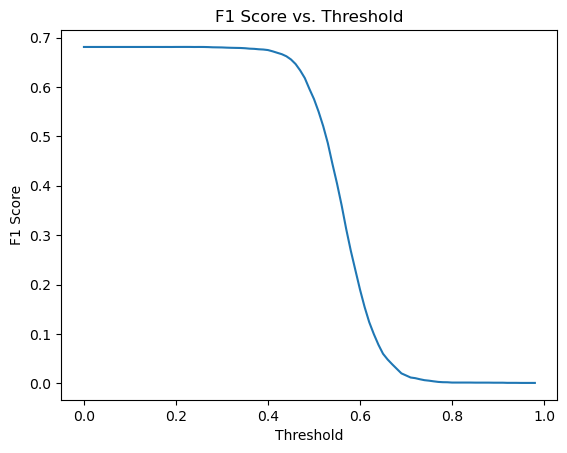

In [36]:
plt.figure()
plt.plot(thresholds, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.show()

In [37]:
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"\nBest threshold = {best_threshold:.2f} with F1 Score = {best_f1:.4f}")


Best threshold = 0.22 with F1 Score = 0.6810


In [43]:
y_final = y_prices_train_meta * prices_train_meta['best_predictions']


→ Fold 0 …

→ Fold 1 …

→ Fold 2 …


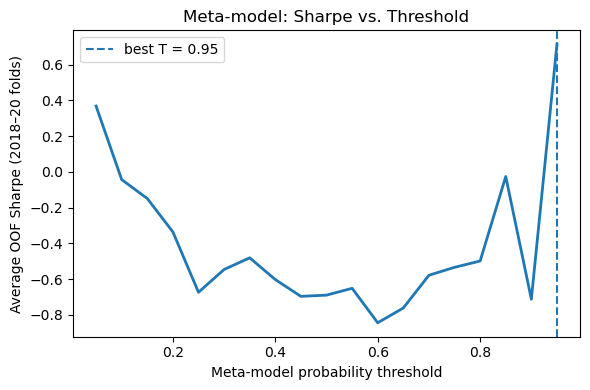


>>> Optimal Threshold  T* ≈ 0.95   (avg OOF Sharpe = 0.713)


In [44]:


# (1) Align all data on the same index
#    df_price["close"], X_meta, y_meta are all indexed by the same hourly DateTimeIndex
common_idx = y_final.index
df_price = prices.loc[common_idx]
X_meta   = X_prices_train_meta.loc[common_idx]
y_meta   = y_final.loc[common_idx]

# (2) Compute next‐hour return series (we already did this, but re‐align to common_idx)
next_ret = df_price["close"].pct_change().shift(-1).loc[common_idx].values

# (3) Helper: given raw meta‐prob and threshold, compute *net hourly* returns
def meta_strategy_ret(raw_prob, threshold, next_ret, fee_bps=2):
    """
    raw_prob: 1D array, P(y_meta=+1) for each hour in validation slice
    threshold: float in (0,1)
    next_ret: 1D array of next‐hour returns (aligned to same timestamps)
    fee_bps: round‐trip cost in basis points (e.g. 2 bps = 0.02%)
    """
    # (a) Build long/short/flat signal
    sig = np.where(raw_prob >= threshold,   +1,
          np.where(raw_prob <= 1 - threshold, -1, 
                   0))
    # (b) Count “turns” where signal[t] != signal[t-1]; a new trade costs you fees
    turns = np.abs(np.diff(sig, prepend=0)) / 2  
    cost  = turns * (fee_bps / 10_000)      # convert bps→ decimal
    
    # (c) Hourly PnL: if we carry a position at t → ret is sig[t] * next_ret[t]
    #     Then subtract cost for trade at that bar.
    pnl = sig * next_ret - cost
    return pnl[1:]  # drop the very first element since we used prepend=0 above

# (4) TimeSeriesSplit: 5 folds on 2018–2020
tscv = TimeSeriesSplit(n_splits=3)

# (5) Pre‐allocate accumulator for OOF Sharpe per threshold
thr_grid    = np.linspace(0.05, 0.95, 19)   # {0.05,0.10,...,0.95}
accum_sharpe = np.zeros_like(thr_grid)

# (6) Loop over folds
for fold_i, (train_idx, val_idx) in enumerate(tscv.split(X_meta)):
    print(f"\n→ Fold {fold_i} …")
    
    X_tr = X_meta.iloc[train_idx]
    y_tr = y_meta.iloc[train_idx]
    X_val = X_meta.iloc[val_idx]
    
    # (6a) Fit the meta‐model (Ridge) on that fold’s train slice
    meta = Ridge(alpha=0.01, random_state=42, max_iter=5000)
    meta.fit(X_tr, y_tr)
    
    # (6b) Get *raw* scores on validation slice
    raw_score = meta.predict(X_val)  # shape = (#hours_in_val, )
    # If you expect probabilities in [0,1], but ridge can produce outside [0,1],
    # then squash linearly to [0,1]:
    if raw_score.min() < 0 or raw_score.max() > 1:
        raw_prob = (raw_score - raw_score.min()) / (raw_score.max() - raw_score.min() + 1e-9)
    else:
        raw_prob = raw_score.copy()
    
    # (6c) For each threshold, compute OOF Sharpe on this fold
    next_ret_val = next_ret[val_idx]  # next‐hour returns on validation portion
    for i, T in enumerate(thr_grid):
        pnl_series = meta_strategy_ret(raw_prob, T, next_ret_val, fee_bps=2)
        # Annualise the hourly returns:  mu× (24×365) / [sigma × sqrt(24×365)]
        mu = pnl_series.mean() * 24 * 365
        sigma = pnl_series.std()  * np.sqrt(24 * 365)
        sharpe_fold = mu/sigma if sigma > 0 else 0
        accum_sharpe[i] += sharpe_fold  # sum across folds

# (7) Average the OOF Sharpe across the 5 folds
avg_sharpe = accum_sharpe / tscv.get_n_splits()

# (8) Plot Sharpe vs Threshold
plt.figure(figsize=(6,4))
plt.plot(thr_grid, avg_sharpe, lw=2)
plt.xlabel("Meta‐model probability threshold")
plt.ylabel("Average OOF Sharpe (2018–20 folds)")
best_idx = np.nanargmax(avg_sharpe)
plt.axvline(thr_grid[best_idx], ls="--", 
            label=f"best T = {thr_grid[best_idx]:.2f}")
plt.title("Meta‐model: Sharpe vs. Threshold")
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n>>> Optimal Threshold  T* ≈ {thr_grid[best_idx]:.2f}   (avg OOF Sharpe = {avg_sharpe[best_idx]:.3f})")

#### The optimal threshold is found to be approximately 0.2 according to Sharpe ratio calculation and 0.28 with respect to F1-score. We belive 0.28 to be an ideal threshold since it shows robustness and filters out 30% of the trades. 

In [150]:
X_test = X_test[29:]    

In [152]:
X_test['tcn_probabilities_0'] = tcn_year['test_probs'][:,0]
X_test['tcn_probabilities_1'] = tcn_year['test_probs'][:,1]
mapped = tcn_year['test_preds'].copy()
mapped[tcn_year['test_preds'] == 0] = -1
mapped[tcn_year['test_preds'] == 1] = 1
X_test['best_predictions'] = mapped

In [161]:
scaled_X = scaler.transform(X_test)
ridge_scores = ridge.predict(scaled_X)
final_meta_pred = (ridge_scores >= 0.22).astype(int)
X_test['y_hat_backtest'] = final_meta_pred*X_test['best_predictions']

In [158]:
confusion_matrix(final_meta_pred,y_test[29:])

array([[ 168,   82],
       [3850, 4536]])

In [159]:
(X_test['y_hat_backtest']==0).sum()

250

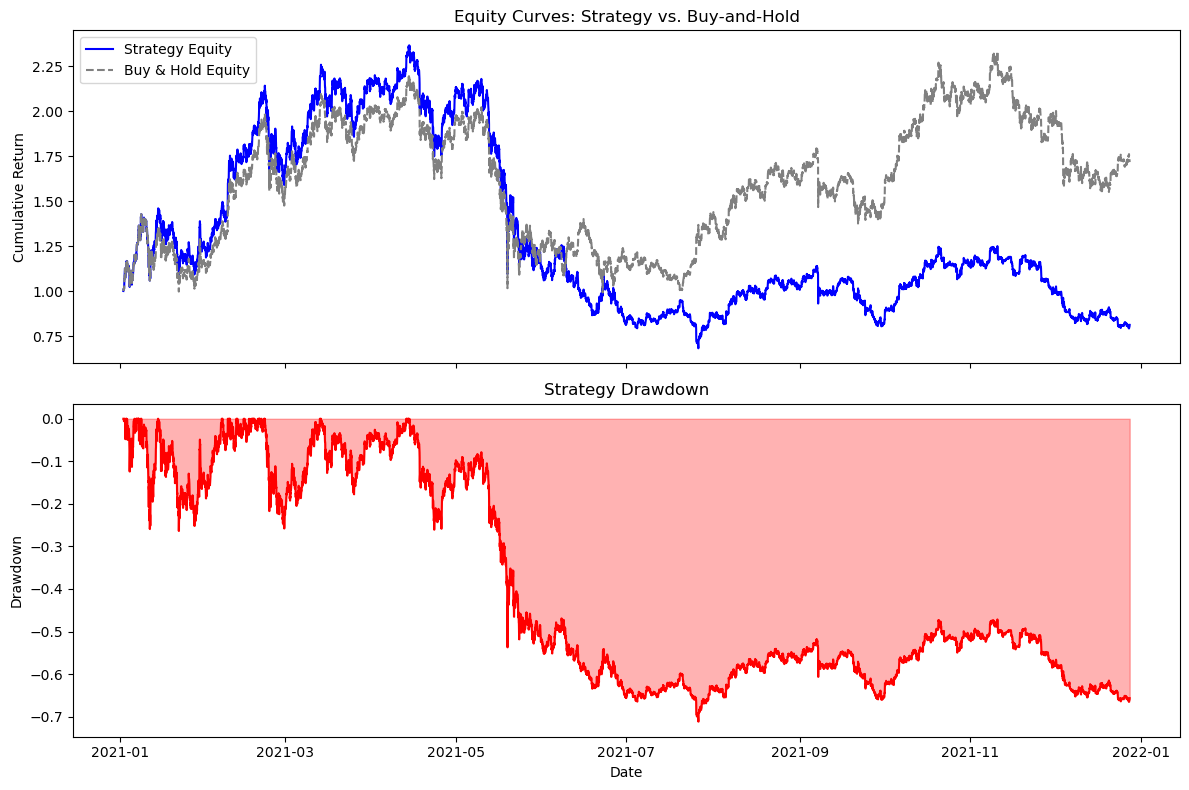

===== BACKTEST METRICS =====
Years                                   : 1.43
Total Return (Strategy)    : -18.80%
CAGR (Strategy)            : -0.1357
Volatility (Strategy)      : 0.7813
Sharpe (Strategy)          : -0.1737
Sortino (Strategy)         : -0.2132
Max Drawdown               : -0.7116
Avg Holding Period (bars)  : 94.21
Total Return (Buy & Hold)  : 71.63%
CAGR (Buy & Hold)          : 0.4598
Volatility (Buy & Hold)    : 0.7857
Sharpe (Buy & Hold)        : 0.5852


In [162]:
def run_backtest(df):
    """
    df must be in ascending time order (row 0 is earliest). 
    It must contain:
      • 'close'           (price at close of each bar)
      • 'y_hat_backtest'  (signal ∈ {+1, 0, -1} indicating long/flat/short for the NEXT bar)
    
    We compute:
      - bar‐to‐bar returns
      - apply each bar’s prior signal to the next bar’s return
      - build an equity curve
      - compute performance metrics and plots
    
    Returns (df_with_metrics, metrics_dict).
    """
    df = df.copy()  # do NOT call sort_index() if your index is mixed

    # 1) Compute simple returns: close[t] / close[t-1] - 1
    #    First bar’s return is set to 0 since there is no prior bar.
    df['ret'] = df['close'].pct_change().fillna(0)

    # 2) Shift the signal forward one bar so that 
    #    the signal value at time t is the position we take into bar (t+1).
    #    If y_hat_backtest[t] = +1, we go long at t’s close, then capture ret[t+1].
    df['signal'] = df['y_hat_backtest'].shift(1).fillna(0)

    # 3) Strategy return: signal[t] * ret[t]
    #    If signal[t]= +1, we capture ret[t]
    #    If signal[t]= -1, we capture -ret[t] (short)
    #    If signal[t]=  0, we capture 0 (flat)
    df['strat_ret'] = df['signal'] * df['ret']

    # 4) Equity curve: compound (1 + strat_ret) from an initial capital of 1.0
    df['equity'] = (1 + df['strat_ret']).cumprod()

    # 5) Build a simple Buy‐and‐Hold (BnH) for comparison: compound (1 + ret)
    df['bnh_equity'] = (1 + df['ret']).cumprod()

    # 6) Drawdowns: 
    df['rolling_max'] = df['equity'].cummax()
    df['drawdown']    = (df['equity'] - df['rolling_max']) / df['rolling_max']
    max_drawdown      = df['drawdown'].min()  # e.g. -0.25 means a 25% peak‐to‐valley drop

    # 7) Figure out annualization factor based on frequency:
    freq = pd.infer_freq(df.index)
    if freq is None or freq.startswith('D'):
        annual_factor = 252
    elif freq.startswith('H'):
        annual_factor = 252 * 24
    elif freq.startswith('T') or freq.startswith('min'):
        annual_factor = 252 * 24 * 60
    else:
        annual_factor = 252

    # 8) Performance metrics:
    #  8a) Total return = equity[-1] - 1
    total_return = df['equity'].iloc[-1] - 1
    n_years      = len(df) / annual_factor

    #  8b) CAGR
    cagr = df['equity'].iloc[-1] ** (1.0 / n_years) - 1

    #  8c) Annualized volatility of strategy returns
    ann_vol = df['strat_ret'].std() * np.sqrt(annual_factor)

    #  8d) Sharpe ratio (assume rf=0)
    sharpe = cagr / ann_vol if ann_vol != 0 else np.nan

    #  8e) Sortino ratio: only “downside” volatility (neg. returns)
    neg_ret_mask = df['strat_ret'] < 0
    if neg_ret_mask.any():
        downside_dev = df.loc[neg_ret_mask, 'strat_ret'].std() * np.sqrt(annual_factor)
    else:
        downside_dev = 0.0
    sortino = cagr / downside_dev if downside_dev != 0 else np.nan

    #  8f) Maximum drawdown already computed as max_drawdown

    #  8g) Average Holding Period (in bars):
    #      Count consecutive runs of nonzero ⁠ signal ⁠ and average their lengths.
    signal_arr = df['signal'].fillna(0).values
    hold_lengths = []
    current_len = 0
    for s in signal_arr:
        if s != 0:
            current_len += 1
        else:
            if current_len > 0:
                hold_lengths.append(current_len)
            current_len = 0
    if current_len > 0:
        hold_lengths.append(current_len)
    avg_holding = np.mean(hold_lengths) if hold_lengths else 0

    #  8h) Buy‐and‐Hold comparators
    total_return_bnh = df['bnh_equity'].iloc[-1] - 1
    cagr_bnh         = df['bnh_equity'].iloc[-1] ** (1.0 / n_years) - 1
    ann_vol_bnh      = df['ret'].std() * np.sqrt(annual_factor)
    sharpe_bnh       = cagr_bnh / ann_vol_bnh if ann_vol_bnh != 0 else np.nan

    # 9) Collect metrics into a dictionary
    metrics = {
        "CAGR_strategy":       cagr,
        "Volatility_strategy": ann_vol,
        "Sharpe_strategy":     sharpe,
        "Sortino_strategy":    sortino,
        "MaxDrawdown":         max_drawdown,
        "AvgHoldingBars":      avg_holding,
        "TotalReturn_strategy": total_return,
        "CAGR_BnH":            cagr_bnh,
        "Volatility_BnH":      ann_vol_bnh,
        "Sharpe_BnH":          sharpe_bnh,
        "TotalReturn_BnH":     total_return_bnh,
        "Years":               n_years
    }

    # 10) Plot the equity curves and drawdown
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # 10a) Equity curves
    ax1.plot(df.index, df['equity'], label="Strategy Equity", color="blue")
    ax1.plot(df.index, df['bnh_equity'], label="Buy & Hold Equity", color="gray", linestyle="--")
    ax1.set_ylabel("Cumulative Return")
    ax1.legend(loc="upper left")
    ax1.set_title("Equity Curves: Strategy vs. Buy‐and‐Hold")

    # 10b) Drawdown plot
    ax2.plot(df.index, df['drawdown'], color="red")
    ax2.fill_between(df.index, df['drawdown'], 0, color="red", alpha=0.3)
    ax2.set_ylabel("Drawdown")
    ax2.set_xlabel("Date")
    ax2.set_title("Strategy Drawdown")
    plt.tight_layout()
    plt.show()

    # 11) Print metrics in a neat format
    print("===== BACKTEST METRICS =====")
    print(f"Years                                   : {n_years:.2f}")
    print(f"Total Return (Strategy)    : {total_return:.2%}")
    print(f"CAGR (Strategy)            : {cagr:.4f}")
    print(f"Volatility (Strategy)      : {ann_vol:.4f}")
    print(f"Sharpe (Strategy)          : {sharpe:.4f}")
    print(f"Sortino (Strategy)         : {sortino:.4f}")
    print(f"Max Drawdown               : {max_drawdown:.4f}")
    print(f"Avg Holding Period (bars)  : {avg_holding:.2f}")
    print(f"Total Return (Buy & Hold)  : {total_return_bnh:.2%}")
    print(f"CAGR (Buy & Hold)          : {cagr_bnh:.4f}")
    print(f"Volatility (Buy & Hold)    : {ann_vol_bnh:.4f}")
    print(f"Sharpe (Buy & Hold)        : {sharpe_bnh:.4f}")
    print("=" * 40)

    return df, metrics

# ───────────────────────────────────────────────────────────────────────────────
# USAGE EXAMPLE:
# ───────────────────────────────────────────────────────────────────────────────

# Suppose you have already built ⁠ df_backtest ⁠, which:
#   • Is indexed by datetime (hourly or daily)
#   • Contains columns "close" and "y_hat_backtest" (values +1, 0, −1).
#
# First ensure there are no NaN signals:

# Then call:
df_with_metrics, backtest_metrics = run_backtest(X_test)

# The returned DataFrame ⁠ df_with_metrics ⁠ now has extra columns:
#     ['ret', 'signal', 'strat_ret', 'equity', 'bnh_equity', 'rolling_max', 'drawdown']
# And ⁠ backtest_metrics ⁠ is a dict containing your numeric summary (CAGR, Sharpe, etc.).

### Backtesting on 2021